In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qulacs import DensityMatrix
from qulacs.state import partial_trace, tensor_product
from qulacs.gate import X, H, CNOT, PauliRotation, DepolarizingNoise

In [2]:
def noisy_time_evolution(rho_input, n_qubit, layer, theta, p_err):
    rho = rho_input.copy()
    for l in range(layer):
        for n in range(n_qubit // 2):
            PauliRotation([2*n, 2*n+1], [1, 1], theta).update_quantum_state(rho)
            PauliRotation([2*n, 2*n+1], [2, 2], theta).update_quantum_state(rho)
            PauliRotation([2*n, 2*n+1], [3, 3], theta).update_quantum_state(rho)

        for n in range(n_qubit // 2 - 1):
            PauliRotation([2*n+1, 2*n+2], [1, 1], theta).update_quantum_state(rho)
            PauliRotation([2*n+1, 2*n+2], [2, 2], theta).update_quantum_state(rho)
            PauliRotation([2*n+1, 2*n+2], [3, 3], theta).update_quantum_state(rho)

        for n in range(n_qubit):
            DepolarizingNoise(n, p_err).update_quantum_state(rho)
    
    return rho



def symmetry_verification(rho_input, n_qubit, layer, theta, p_err):
    rho = rho_input.copy()

    # U
    rho = noisy_time_evolution(rho, n_qubit, layer, theta, p_err)

    # measurement
    rho_ancilla = DensityMatrix(1)
    rho = tensor_product(rho_ancilla, rho)

    for n in range(n_qubit):
        CNOT(n, n_qubit).update_quantum_state(rho)

    completely_mixed_state = DensityMatrix(n_qubit)
    completely_mixed_state.load(np.identity(2**n_qubit))
    projector = tensor_product(DensityMatrix(1), completely_mixed_state)
    if n_qubit % 4 == 2:
        X(n_qubit).update_quantum_state(projector)
    rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
    rho.load(rho_matrix)
    rho = partial_trace(rho, [n_qubit])

    return rho



def symmetric_channel_verification(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, gate_error_ratio=100, with_ancilla_noise = False):
    p_err_gadget = p_err / gate_error_ratio
    layer_per_purification = layer // verification_frequensy
    n_ancilla = 2
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
            
        H(n_qubit).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n, n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n_qubit, n).update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)
        
        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n_qubit+n, 1-(1-p_err)**layer_per_purification).update_quantum_state(rho)

        # U_D
        for n in range(n_qubit):
            CNOT(n, n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n_qubit, n).update_quantum_state(rho)
        H(n_qubit).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit+i for i in range(n_ancilla)])

    return rho





def symmetric_channel_verification_flag(rho_input, n_qubit, layer, theta, p_err, verification_frequensy = 1, gadget_error_ratio=100, with_ancilla_noise = True):
    p_err_gadget = p_err / gadget_error_ratio
    layer_per_purification = layer // verification_frequensy
    n_ancilla = 4
    rho = rho_input.copy()

    for verification_step in range(verification_frequensy):
        rho_ancilla = DensityMatrix(n_ancilla)
        rho = tensor_product(rho_ancilla, rho)

        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        H(n_qubit).update_quantum_state(rho)
        H(n_qubit+3).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n, n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n_qubit, n).update_quantum_state(rho)
        CNOT(n_qubit, n_qubit+2).update_quantum_state(rho)
        CNOT(n_qubit+3, n_qubit+1).update_quantum_state(rho)

        # U
        rho = noisy_time_evolution(rho, n_qubit, layer_per_purification, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n_qubit+n, 1-(1-p_err)**layer_per_purification).update_quantum_state(rho)

        # U_D
        CNOT(n_qubit, n_qubit+2).update_quantum_state(rho)
        CNOT(n_qubit+3, n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n, n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(n_qubit, n).update_quantum_state(rho)
        H(n_qubit).update_quantum_state(rho)
        H(n_qubit+3).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

        rho = partial_trace(rho, [n_qubit+i for i in range(n_ancilla)])

    return rho

In [3]:
n_qubit = 8
layer = 100
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / layer

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_state_list = np.zeros(len(p_err_list))
tracedist_channel_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    for n in range(n_qubit//2):
        X(2*n).update_quantum_state(rho_initial)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_state = symmetry_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel_layerwise = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err,verification_frequensy=layer)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_state = rho_state.get_matrix()
    rho_channel = rho_channel.get_matrix()
    rho_channel_layerwise = rho_channel_layerwise.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_state_list[p_index] = np.linalg.norm(rho_ideal - rho_state / np.trace(rho_state), ord = 'nuc') / 2
    tracedist_channel_list[p_index] = np.linalg.norm(rho_ideal - rho_channel / np.trace(rho_channel), ord = 'nuc') / 2
    tracedist_channel_layerwise_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise / np.trace(rho_channel_layerwise), ord = 'nuc') / 2

    print(p_index)

0
1
2
3
4
5
6


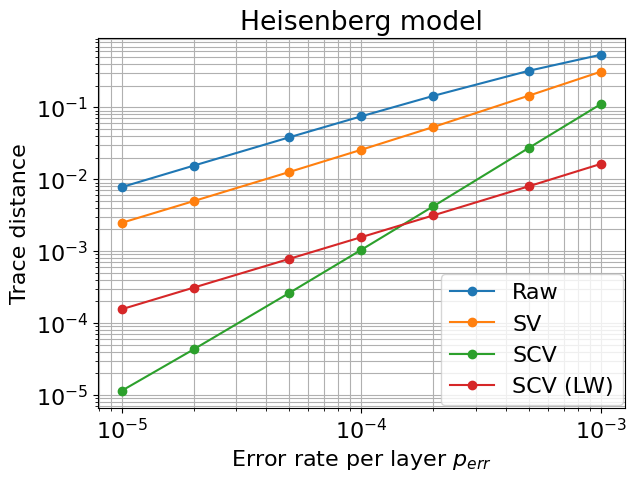

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(p_err_list, tracedist_state_list, marker = 'o', label = 'SV')
plt.plot(p_err_list, tracedist_channel_list, marker = 'o', label = 'SCV')
plt.plot(p_err_list, tracedist_channel_layerwise_list, marker = 'o', label = 'SCV (LW)')

plt.xscale('log')
plt.yscale('log')
plt.title('Heisenberg model')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('Heisenberg.pdf', bbox_inches='tight')

In [3]:
n_qubit = 4
layer = 100
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / 100

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_state_list = np.zeros(len(p_err_list))
tracedist_channel_list = np.zeros(len(p_err_list))
tracedist_channel_noisy_list = np.zeros(len(p_err_list))
tracedist_channel_flag_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_noisy_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_flag_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    for n in range(n_qubit//2):
        X(2*n).update_quantum_state(rho_initial)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_state = symmetry_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=False)
    rho_channel_noisy = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=True)
    rho_channel_flag = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=True)
    rho_channel_layerwise = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err, verification_frequensy=layer, with_ancilla_noise=False)
    rho_channel_layerwise_noisy = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err,verification_frequensy=layer, with_ancilla_noise=True)
    rho_channel_layerwise_flag = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err,verification_frequensy=layer, with_ancilla_noise=True)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_state = rho_state.get_matrix()
    rho_channel = rho_channel.get_matrix()
    rho_channel_noisy = rho_channel_noisy.get_matrix()
    rho_channel_flag = rho_channel_flag.get_matrix()
    rho_channel_layerwise = rho_channel_layerwise.get_matrix()
    rho_channel_layerwise_noisy = rho_channel_layerwise_noisy.get_matrix()
    rho_channel_layerwise_flag = rho_channel_layerwise_flag.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_state_list[p_index] = np.linalg.norm(rho_ideal - rho_state / np.trace(rho_state), ord = 'nuc') / 2
    tracedist_channel_list[p_index] = np.linalg.norm(rho_ideal - rho_channel / np.trace(rho_channel), ord = 'nuc') / 2
    tracedist_channel_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_noisy / np.trace(rho_channel_noisy), ord = 'nuc') / 2
    tracedist_channel_flag_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_flag / np.trace(rho_channel_flag), ord = 'nuc') / 2
    tracedist_channel_layerwise_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise / np.trace(rho_channel_layerwise), ord = 'nuc') / 2
    tracedist_channel_layerwise_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise_noisy / np.trace(rho_channel_layerwise_noisy), ord = 'nuc') / 2
    tracedist_channel_layerwise_flag_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise_flag / np.trace(rho_channel_layerwise_flag), ord = 'nuc') / 2

    print(p_index)

0
1
2
3
4
5
6


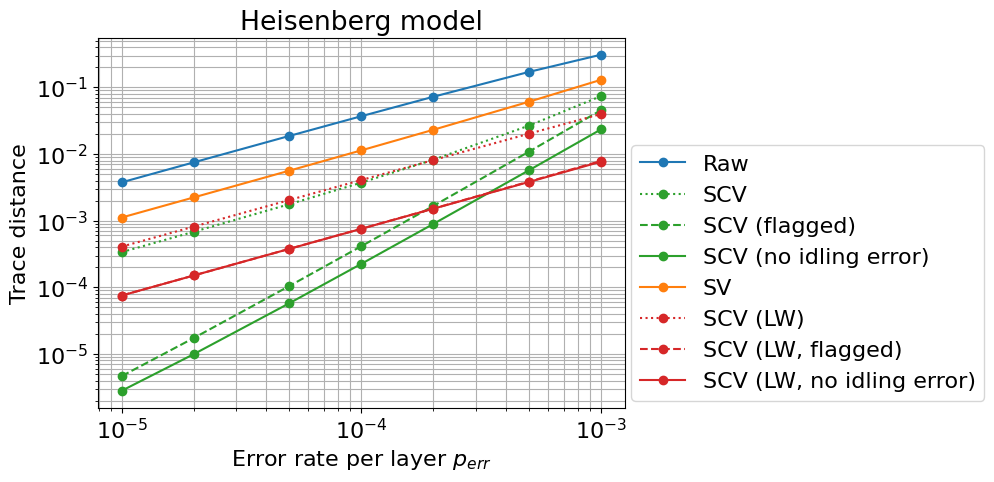

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(p_err_list, tracedist_state_list, marker = 'o', label = 'SV')
plt.plot(p_err_list, tracedist_channel_noisy_list, marker = 'o', color = 'tab:green', linestyle = ':', label = 'SCV')
plt.plot(p_err_list, tracedist_channel_flag_list, marker = 'o', color = 'tab:green', linestyle = '--', label = 'SCV (flagged)')
plt.plot(p_err_list, tracedist_channel_list, marker = 'o', color = 'tab:green', linestyle = '-', label = 'SCV (no idling error)')
plt.plot(p_err_list, tracedist_channel_layerwise_noisy_list, marker = 'o', color = 'tab:red', linestyle = ':', label = 'SCV (LW)')
plt.plot(p_err_list, tracedist_channel_layerwise_flag_list, marker = 'o', color = 'tab:red', linestyle = '--', label = 'SCV (LW, flagged)')
plt.plot(p_err_list, tracedist_channel_layerwise_list, marker = 'o', color = 'tab:red', linestyle = '-', label = 'SCV (LW, no idling error)')

plt.xscale('log')
plt.yscale('log')
plt.title('Heisenberg model')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
plt.legend(bbox_to_anchor=(1,0),loc='lower left',borderaxespad=0.3)
plt.grid(which='both', axis='both')
#plt.savefig('Heisenberg_flag.pdf', bbox_inches='tight')

In [10]:
n_qubit = 4
layer = 100
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / 100

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_state_list = np.zeros(len(p_err_list))
tracedist_channel_list = np.zeros(len(p_err_list))
tracedist_channel_FTQC_list = np.zeros(len(p_err_list))
tracedist_channel_NISQ_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_FTQC_list = np.zeros(len(p_err_list))
tracedist_channel_layerwise_NISQ_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    for n in range(n_qubit//2):
        X(2*n).update_quantum_state(rho_initial)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_state = symmetry_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel_FTQC = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, gadget_error_ratio=100, with_ancilla_noise=True)
    rho_channel_NISQ = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, gadget_error_ratio=1, with_ancilla_noise=True)
    rho_channel_layerwise_FTQC = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, verification_frequensy=layer, gadget_error_ratio=100, with_ancilla_noise=True)
    rho_channel_layerwise_NISQ = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, verification_frequensy=layer, gadget_error_ratio=1, with_ancilla_noise=True)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_state = rho_state.get_matrix()
    rho_channel_FTQC = rho_channel_FTQC.get_matrix()
    rho_channel_NISQ = rho_channel_NISQ.get_matrix()
    rho_channel_layerwise_FTQC = rho_channel_layerwise_FTQC.get_matrix()
    rho_channel_layerwise_NISQ = rho_channel_layerwise_NISQ.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_state_list[p_index] = np.linalg.norm(rho_ideal - rho_state / np.trace(rho_state), ord = 'nuc') / 2
    tracedist_channel_FTQC_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_FTQC / np.trace(rho_channel_FTQC), ord = 'nuc') / 2
    tracedist_channel_NISQ_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_NISQ / np.trace(rho_channel_NISQ), ord = 'nuc') / 2
    tracedist_channel_layerwise_FTQC_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise_FTQC / np.trace(rho_channel_layerwise_FTQC), ord = 'nuc') / 2
    tracedist_channel_layerwise_NISQ_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_layerwise_NISQ / np.trace(rho_channel_layerwise_NISQ), ord = 'nuc') / 2

    print(p_index)

0
1
2
3
4
5
6


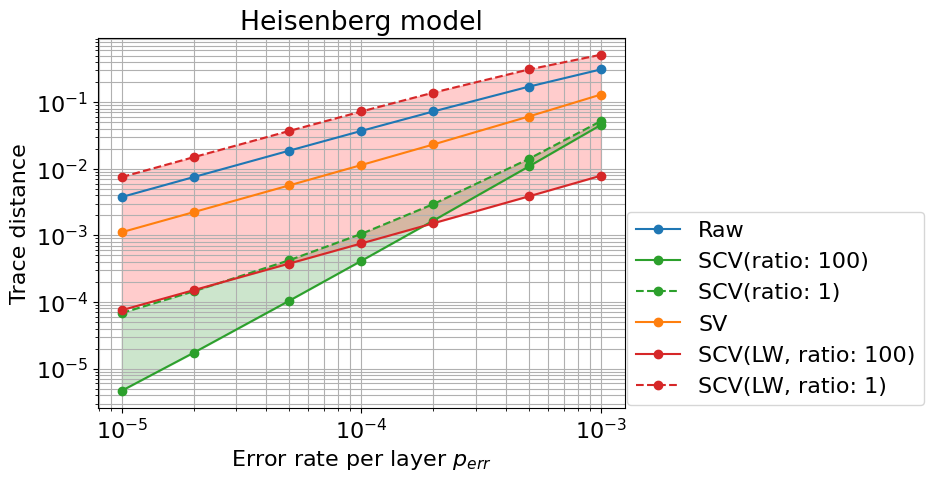

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(p_err_list, tracedist_state_list, marker = 'o', label = 'SV')
plt.plot(p_err_list, tracedist_channel_FTQC_list, marker = 'o', color = 'tab:green', linestyle = '-', label = 'SCV(ratio: 100)')
plt.plot(p_err_list, tracedist_channel_NISQ_list, marker = 'o', color = 'tab:green', linestyle = '--', label = 'SCV(ratio: 1)')
plt.plot(p_err_list, tracedist_channel_layerwise_FTQC_list, marker = 'o', color = 'tab:red', linestyle = '-', label = 'SCV(LW, ratio: 100)')
plt.plot(p_err_list, tracedist_channel_layerwise_NISQ_list, marker = 'o', color = 'tab:red', linestyle = '--', label = 'SCV(LW, ratio: 1)')

plt.fill_between(
    p_err_list,
    tracedist_channel_FTQC_list,
    tracedist_channel_NISQ_list,
    color='green',
    alpha=0.2
)

plt.fill_between(
    p_err_list,
    tracedist_channel_layerwise_FTQC_list,
    tracedist_channel_layerwise_NISQ_list,
    color='red',
    alpha=0.2
)

plt.xscale('log')
plt.yscale('log')
plt.title('Heisenberg model')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
plt.legend(bbox_to_anchor=(1,0),loc='lower left',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('Heisenberg_NISQ.pdf', bbox_inches='tight')